<a href="https://colab.research.google.com/github/AIBYTECH/Computer-vision/blob/main/pytorch_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

**We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`**

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Can you figure out the purpose of the arguments `num_workers` and `pin_memory`? Try looking into the documentation: https://pytorch.org/docs/stable/data.html .

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

images.shape: torch.Size([128, 1, 28, 28])


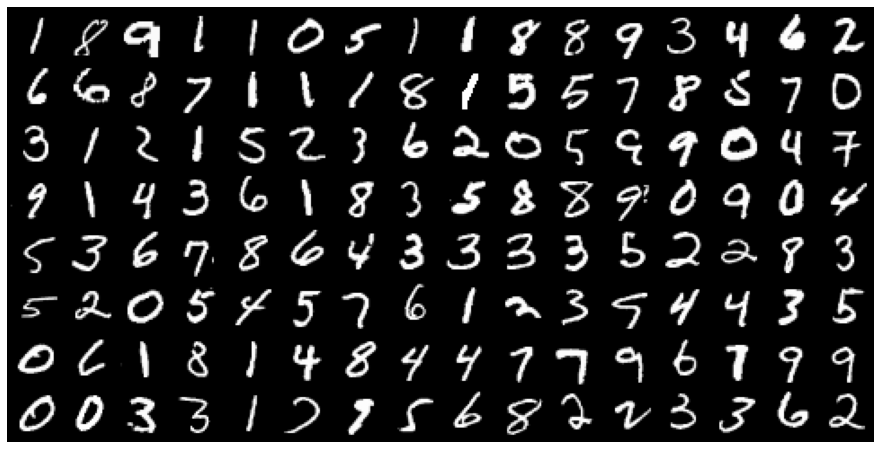

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [ ]:
len(inputs)

128

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1

Linear(in_features=784, out_features=32, bias=True)

In [ ]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [ ]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [ ]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [ ]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7460916638374329
min(relu_outputs): 0.0


In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [ ]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3153, grad_fn=<NllLossBackward0>)

In [ ]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [ ]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [ ]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [ ]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [ ]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [ ]:
torch.allclose(outputs2, outputs3, 1e-3)

True

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 2.307229518890381
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2466,  0.2537,  0.0233,  0.1111, -0.1562, -0.1513, -0.1117,  0.0619,
         -0.2147,  0.0692],
        [ 0.1708,  0.2967,  0.0378,  0.0087, -0.3140, -0.0757, -0.0272,  0.1120,
         -0.1611, -0.1377]])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([3, 8, 1, 5, 9, 1, 9, 5, 7, 7, 2, 0, 4, 3, 1, 1, 2, 3, 7, 1, 2, 6, 6, 3,
        8, 3, 5, 5, 2, 3, 4, 5, 9, 9, 1, 6, 6, 0, 2, 8, 7, 4, 6, 7, 1, 9, 9, 3,
        1, 2, 1, 1, 9, 1, 9, 4, 7, 4, 0, 8, 8, 9, 8, 8, 6, 4, 4, 1, 8, 7, 0, 1,
        6, 6, 7, 9, 7, 9, 9, 9, 6, 0, 3, 1, 0, 9, 0, 5, 5, 5, 5, 5, 6, 8, 8, 5,
        1, 0, 2, 5, 9, 1, 9, 6, 7, 3, 7, 6, 9, 2, 8, 1, 0, 4, 1, 8, 3, 8, 1, 3,
        4, 9, 7, 1, 4, 4, 3, 8, 2, 0, 0, 6, 1, 8, 6, 1, 7, 3, 4, 6, 8, 7, 3, 7,
        3, 1, 4, 7, 8, 5, 9, 4, 8, 1, 8, 9, 3, 8, 5, 5, 4, 8, 7, 4, 4, 8, 6, 2,
        1, 5, 5, 6, 2, 2, 3, 6, 4, 0, 3, 0, 3, 8, 2, 1, 1, 7, 0, 8, 6, 9, 6, 1,
        8, 2, 7, 5, 7, 7, 3, 6, 8, 6, 2, 0, 1, 7, 6, 2, 6, 6, 5, 7, 6, 9, 1, 7,
        9, 0, 2, 4, 7, 0, 9, 7, 3, 0, 5, 5, 0, 1, 1, 9, 5, 0, 5, 9, 4, 5, 9, 2,
        2, 7, 9, 4, 9, 8, 8, 7, 1, 1, 6, 1, 0, 2, 8, 4], device='cuda:0')


In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_loss': 2.3190436363220215, 'val_acc': 0.07597656548023224}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2629, val_acc: 0.9255
Epoch [1], val_loss: 0.1961, val_acc: 0.9436
Epoch [2], val_loss: 0.1896, val_acc: 0.9452
Epoch [3], val_loss: 0.1507, val_acc: 0.9544
Epoch [4], val_loss: 0.1518, val_acc: 0.9547


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1253, val_acc: 0.9657
Epoch [1], val_loss: 0.1224, val_acc: 0.9663
Epoch [2], val_loss: 0.1211, val_acc: 0.9668
Epoch [3], val_loss: 0.1202, val_acc: 0.9674
Epoch [4], val_loss: 0.1204, val_acc: 0.9668


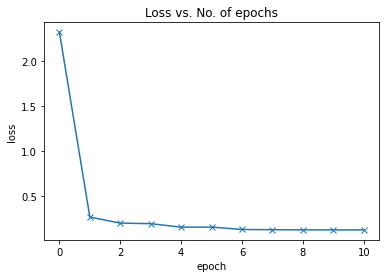

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

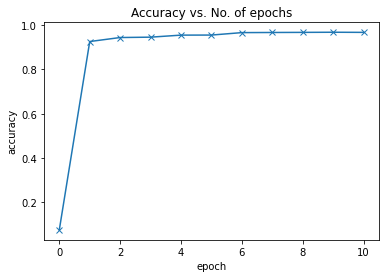

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


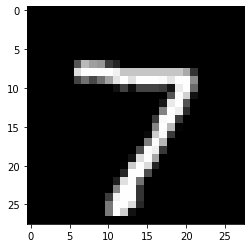

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


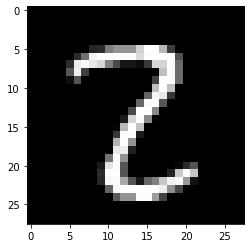

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10533430427312851, 'val_acc': 0.968945324420929}

In [ ]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')